In [1]:
from code.mnist_NA import *
from code.helper_FMP import *
import tensorflow as tf
import numpy as np
import pandas as pd
import glob

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split
from tqdm import tnrange,tqdm_notebook
import os 

import warnings
warnings.filterwarnings("ignore")

In [2]:
epochs = 20
batch_size = 16

logs_path = "tensorflow_logs/mnist_logs"
model_path  = "/models/mnist"

In [3]:
os.getcwd()

'/home/prakash/benchmark'

In [4]:
filelist_train = glob.glob(os.getcwd()+"/train/*.png")
filelist_test = glob.glob(os.getcwd()+"/test/*.png")

In [5]:
filelist_train[0]

'/home/prakash/benchmark/train/11934.png'

In [6]:
train= np.array([image_read(filelist_train[i]) for i in range(len(filelist_train))])
test = np.array([image_read(filelist_test[i]) for i in range(len(filelist_test))])

In [7]:
train.shape

(49000, 36, 36, 3)

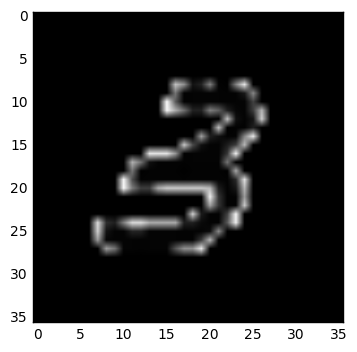

In [8]:
plt.imshow(train[100,:,:,:])
plt.show()

In [9]:
labels = pd.read_table(os.getcwd()+"/train.csv",sep=",",index_col = ["filename"])
labels = labels.ix[list(map(int, ([x.rsplit('/',1)[-1].rsplit('.',1)[0] for x in filelist_train])))]
labels = pd.get_dummies(labels['label'])
labels = labels.as_matrix()
print (labels)

[[ 0.  0.  0. ...,  1.  0.  0.]
 [ 0.  0.  1. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  1.  0.  0.]
 ..., 
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 0.  1.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


In [10]:
trX,valX,trY, valY = train_test_split(train,labels,
	test_size = 0.20, random_state = 20)

In [11]:
# model building 
X = tf.placeholder(tf.float32,[None,36,36,3],name = "Input_data")
Y = tf.placeholder(tf.float32,[None,10], name = "InputLabels")

In [12]:
weights = {
"w1":init_weights([2,2,3,32]),
"w2":init_weights([2,2,32,64]),
"w3":init_weights([2,2,64,96]),
"w4":init_weights([2,2,96,128]),
"w5":init_weights([2,2,128,160]),
"w6":init_weights([2,2,160,192]),
"w7":init_weights([1,1,192,192]),
"w8":init_weights([1,1,192,192]),
"w9":init_weights([1728,10])
}



bias = {
"b1": init_bias([32]),
"b2": init_bias([64]),
"b3": init_bias([96]),
"b4": init_bias([128]),
"b5": init_bias([160]),
"b6": init_bias([192]),
"b7": init_bias([192]),
"b8": init_bias([192]),
"b9": init_bias([10])
}

In [13]:
pred = model(X,weights,bias)

In [14]:
pred

<tf.Tensor 'Add:0' shape=(?, 10) dtype=float32>

In [15]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred,Y))
#optimizer = tf.train.AdamOptimizer(learning_rate=0.00001).minimize(cost)
optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost)

In [16]:
#Evaluate the model
correct_pred= tf.equal(tf.argmax(pred,1),tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred,tf.float32))

#Initialize all the variables
init = tf.initialize_all_variables()

saver = tf.train.Saver()

In [17]:
# Create summary to monitor cost tensor , accuracy tensor
tf.scalar_summary("loss",cost)
tf.scalar_summary("accuracy",accuracy)

merged_summary_op = tf.merge_all_summaries()

In [19]:
with tf.Session() as sess:
    sess.run(init)
    summary_writer = tf.train.SummaryWriter(logs_path,graph=tf.get_default_graph())
    val_acc = [0]
    for ep in tqdm_notebook(range(epochs),desc="1st loop"):
        batches = int(len(trX)/batch_size)
        x_train,y_train = shuffle(trX,trY,random_state=0)
        for i in tqdm_notebook(range(batches),desc="2nd loop", leave = False):
            X_train, Y_train = x_train[i*batch_size:(i+1)*batch_size],y_train[i*batch_size:(i+1)*batch_size]
            _,c,summary = sess.run([optimizer,cost,merged_summary_op],feed_dict={X : np.float32(X_train), Y : np.float32(Y_train)})
            if i % 1000 == 0:
                train_loss, train_acc = sess.run([cost,accuracy], feed_dict={X : np.float32(x_train[0:1000,:,:,:]), Y : np.float32(y_train[0:1000])})
                valx,valy = shuffle(valX,valY, random_state=0)
                valid_loss, valid_acc = sess.run([cost,accuracy], feed_dict={X : np.float32(valx[0:1000]), Y : np.float32(valy[0:1000])})
                print (str(ep),str(i),"Train loss ="+"{:.6f}".format(train_loss),\
                       "Train acc ="+"{:.6f}".format(train_acc),\
                      "valid loss ="+"{:.6f}".format(valid_loss),\
                      "valid acc ="+"{:.6f}".format(valid_acc))
                if max(val_acc) < valid_acc:
                    val_acc.append(valid_acc)
                    saver.save(sess,os.getcwd()+model_path+"_"+str(ep)+"_"+str(i))
    print ("Optimization finished")
                
                

0 0 Train loss =2.302590 Train acc =0.098000 valid loss =2.302548 valid acc =0.105000
0 1000 Train loss =2.301074 Train acc =0.115000 valid loss =2.300365 valid acc =0.104000
0 2000 Train loss =2.299824 Train acc =0.115000 valid loss =2.299810 valid acc =0.104000
1 0 Train loss =1.841220 Train acc =0.263000 valid loss =1.641279 valid acc =0.381000
1 1000 Train loss =0.796329 Train acc =0.755000 valid loss =1.007066 valid acc =0.672000
1 2000 Train loss =0.366906 Train acc =0.876000 valid loss =0.358619 valid acc =0.887000
2 0 Train loss =0.331030 Train acc =0.900000 valid loss =0.424946 valid acc =0.877000
2 1000 Train loss =0.413063 Train acc =0.874000 valid loss =0.341812 valid acc =0.884000
2 2000 Train loss =0.207069 Train acc =0.933000 valid loss =0.171587 valid acc =0.951000
3 0 Train loss =0.206459 Train acc =0.940000 valid loss =0.305751 valid acc =0.908000
3 1000 Train loss =0.360316 Train acc =0.878000 valid loss =0.280711 valid acc =0.921000
3 2000 Train loss =0.145471 Train

In [20]:
val_acc

[0,
 0.105,
 0.38100004,
 0.67199999,
 0.88700002,
 0.95100003,
 0.95400012,
 0.97400004,
 0.97600001,
 0.97899997,
 0.97900009]

In [ ]:
# reducing the learning rate and running more epochs 
optimizer = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(cost)

In [21]:
# remove val_accuarcy- that will set it to default 
with tf.Session() as sess:
    sess.run(init)
    summary_writer = tf.train.SummaryWriter(logs_path,graph=tf.get_default_graph())
    saver.restore(sess,os.getcwd()+model_path+"_"+"17"+"_"+"2000")
    for ep in tqdm_notebook(range(epochs),desc="1st loop"):
        batches = int(len(trX)/batch_size)
        x_train,y_train = shuffle(trX,trY,random_state=0)
        for i in tqdm_notebook(range(batches),desc="2nd loop", leave = False):
            X_train, Y_train = x_train[i*batch_size:(i+1)*batch_size],y_train[i*batch_size:(i+1)*batch_size]
            _,c,summary = sess.run([optimizer,cost,merged_summary_op],feed_dict={X : np.float32(X_train), Y : np.float32(Y_train)})
            if i % 1000 == 0:
                train_loss, train_acc = sess.run([cost,accuracy], feed_dict={X : np.float32(x_train[0:1000,:,:,:]), Y : np.float32(y_train[0:1000])})
                valx,valy = shuffle(valX,valY, random_state=0)
                valid_loss, valid_acc = sess.run([cost,accuracy], feed_dict={X : np.float32(valx[0:1000]), Y : np.float32(valy[0:1000])})
                print (str(ep),str(i),"Train loss ="+"{:.6f}".format(train_loss),\
                       "Train acc ="+"{:.6f}".format(train_acc),\
                      "valid loss ="+"{:.6f}".format(valid_loss),\
                      "valid acc ="+"{:.6f}".format(valid_acc))
                if max(val_acc) < valid_acc:
                    val_acc.append(valid_acc)
                    saver.save(sess,os.getcwd()+model_path+"_"+"run2"+"_"+str(ep)+"_"+str(i))
    print ("Optimization finished")

0 0 Train loss =0.098165 Train acc =0.967000 valid loss =0.151144 valid acc =0.959000
0 1000 Train loss =0.139033 Train acc =0.970000 valid loss =0.231926 valid acc =0.951000
0 2000 Train loss =0.078833 Train acc =0.973000 valid loss =0.163542 valid acc =0.953000
1 0 Train loss =0.101336 Train acc =0.968000 valid loss =0.097532 valid acc =0.973000
1 1000 Train loss =0.284841 Train acc =0.912000 valid loss =0.305751 valid acc =0.905000
1 2000 Train loss =0.112236 Train acc =0.965000 valid loss =0.241569 valid acc =0.930000
2 0 Train loss =0.147014 Train acc =0.953000 valid loss =0.161332 valid acc =0.959000
2 1000 Train loss =0.474135 Train acc =0.860000 valid loss =0.502667 valid acc =0.859000
2 2000 Train loss =0.242465 Train acc =0.927000 valid loss =0.248673 valid acc =0.939000
3 0 Train loss =0.173770 Train acc =0.958000 valid loss =0.182960 valid acc =0.948000
3 1000 Train loss =0.222229 Train acc =0.932000 valid loss =0.288344 valid acc =0.922000
3 2000 Train loss =0.220576 Train

In [22]:
val_acc

[0,
 0.105,
 0.38100004,
 0.67199999,
 0.88700002,
 0.95100003,
 0.95400012,
 0.97400004,
 0.97600001,
 0.97899997,
 0.97900009,
 0.98299998]

In [31]:
# reducing the learning rate and running more epochs 
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred,Y))
optimizer = tf.train.AdamOptimizer(learning_rate=0.00001).minimize(cost)

init = tf.initialize_all_variables()

In [32]:
# remove val_accuarcy- that will set it to default 
with tf.Session() as sess:
    sess.run(init)
    summary_writer = tf.train.SummaryWriter(logs_path,graph=tf.get_default_graph())
    saver.restore(sess,os.getcwd()+model_path+"_"+"run2"+"_"+"10"+"_"+"2000")
    for ep in tqdm_notebook(range(epochs),desc="1st loop"):
        batches = int(len(trX)/batch_size)
        x_train,y_train = shuffle(trX,trY,random_state=0)
        for i in tqdm_notebook(range(batches),desc="2nd loop", leave = False):
            X_train, Y_train = x_train[i*batch_size:(i+1)*batch_size],y_train[i*batch_size:(i+1)*batch_size]
            _,c,summary = sess.run([optimizer,cost,merged_summary_op],feed_dict={X : np.float32(X_train), Y : np.float32(Y_train)})
            if i % 1000 == 0:
                train_loss, train_acc = sess.run([cost,accuracy], feed_dict={X : np.float32(x_train[0:1000,:,:,:]), Y : np.float32(y_train[0:1000])})
                valx,valy = shuffle(valX,valY, random_state=0)
                valid_loss, valid_acc = sess.run([cost,accuracy], feed_dict={X : np.float32(valx[0:1000]), Y : np.float32(valy[0:1000])})
                print (str(ep),str(i),"Train loss ="+"{:.6f}".format(train_loss),\
                       "Train acc ="+"{:.6f}".format(train_acc),\
                      "valid loss ="+"{:.6f}".format(valid_loss),\
                      "valid acc ="+"{:.6f}".format(valid_acc))
                if max(val_acc) < valid_acc:
                    val_acc.append(valid_acc)
                    saver.save(sess,os.getcwd()+model_path+"_"+"run3"+"_"+str(ep)+"_"+str(i))
    print ("Optimization finished")

0 0 Train loss =0.112754 Train acc =0.972000 valid loss =0.092918 valid acc =0.971000
0 1000 Train loss =0.092681 Train acc =0.977000 valid loss =0.151973 valid acc =0.968000
0 2000 Train loss =0.076151 Train acc =0.974000 valid loss =0.099301 valid acc =0.969000
1 0 Train loss =0.069196 Train acc =0.980000 valid loss =0.090019 valid acc =0.977000
1 1000 Train loss =0.056951 Train acc =0.986000 valid loss =0.067025 valid acc =0.980000
1 2000 Train loss =0.071047 Train acc =0.978000 valid loss =0.065641 valid acc =0.984000
2 0 Train loss =0.164126 Train acc =0.961000 valid loss =0.093142 valid acc =0.973000
2 1000 Train loss =0.120449 Train acc =0.967000 valid loss =0.099341 valid acc =0.978000
2 2000 Train loss =0.097075 Train acc =0.972000 valid loss =0.104550 valid acc =0.968000
3 0 Train loss =0.064887 Train acc =0.984000 valid loss =1.489470 valid acc =0.979000
3 1000 Train loss =0.055873 Train acc =0.979000 valid loss =0.100839 valid acc =0.977000
3 2000 Train loss =0.082534 Train

In [33]:
val_acc

[0,
 0.105,
 0.38100004,
 0.67199999,
 0.88700002,
 0.95100003,
 0.95400012,
 0.97400004,
 0.97600001,
 0.97899997,
 0.97900009,
 0.98299998,
 0.98399997,
 0.98699999,
 0.98899996,
 0.99199998]

In [34]:
# reducing the learning rate and running more epochs 
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred,Y))
optimizer = tf.train.AdamOptimizer(learning_rate=0.000001).minimize(cost)

init = tf.initialize_all_variables()

In [35]:
# remove val_accuarcy- that will set it to default 
with tf.Session() as sess:
    sess.run(init)
    summary_writer = tf.train.SummaryWriter(logs_path,graph=tf.get_default_graph())
    saver.restore(sess,os.getcwd()+model_path+"_"+"run3"+"_"+"14"+"_"+"0")
    for ep in tqdm_notebook(range(epochs),desc="1st loop"):
        batches = int(len(trX)/batch_size)
        x_train,y_train = shuffle(trX,trY,random_state=0)
        for i in tqdm_notebook(range(batches),desc="2nd loop", leave = False):
            X_train, Y_train = x_train[i*batch_size:(i+1)*batch_size],y_train[i*batch_size:(i+1)*batch_size]
            _,c,summary = sess.run([optimizer,cost,merged_summary_op],feed_dict={X : np.float32(X_train), Y : np.float32(Y_train)})
            if i % 1000 == 0:
                train_loss, train_acc = sess.run([cost,accuracy], feed_dict={X : np.float32(x_train[0:1000,:,:,:]), Y : np.float32(y_train[0:1000])})
                valx,valy = shuffle(valX,valY, random_state=0)
                valid_loss, valid_acc = sess.run([cost,accuracy], feed_dict={X : np.float32(valx[0:1000]), Y : np.float32(valy[0:1000])})
                print (str(ep),str(i),"Train loss ="+"{:.6f}".format(train_loss),\
                       "Train acc ="+"{:.6f}".format(train_acc),\
                      "valid loss ="+"{:.6f}".format(valid_loss),\
                      "valid acc ="+"{:.6f}".format(valid_acc))
                if max(val_acc) < valid_acc:
                    val_acc.append(valid_acc)
                    saver.save(sess,os.getcwd()+model_path+"_"+"run4"+"_"+str(ep)+"_"+str(i))
    print ("Optimization finished")

0 0 Train loss =0.049085 Train acc =0.986000 valid loss =0.058823 valid acc =0.986000
0 1000 Train loss =0.039224 Train acc =0.986000 valid loss =0.054207 valid acc =0.985000
0 2000 Train loss =0.047641 Train acc =0.986000 valid loss =0.057346 valid acc =0.985000
1 0 Train loss =0.062885 Train acc =0.982000 valid loss =0.068016 valid acc =0.987000
1 1000 Train loss =0.088306 Train acc =0.975000 valid loss =0.074711 valid acc =0.983000
1 2000 Train loss =0.071275 Train acc =0.980000 valid loss =0.086353 valid acc =0.977000
2 0 Train loss =0.038848 Train acc =0.992000 valid loss =0.066262 valid acc =0.983000
2 1000 Train loss =0.047143 Train acc =0.984000 valid loss =0.048696 valid acc =0.983000
2 2000 Train loss =0.081746 Train acc =0.979000 valid loss =0.046983 valid acc =0.990000
3 0 Train loss =0.047122 Train acc =0.983000 valid loss =0.098130 valid acc =0.984000
3 1000 Train loss =0.052317 Train acc =0.983000 valid loss =0.062606 valid acc =0.986000
3 2000 Train loss =0.050192 Train

In [36]:
val_acc

[0,
 0.105,
 0.38100004,
 0.67199999,
 0.88700002,
 0.95100003,
 0.95400012,
 0.97400004,
 0.97600001,
 0.97899997,
 0.97900009,
 0.98299998,
 0.98399997,
 0.98699999,
 0.98899996,
 0.99199998]

In [37]:
# reducing the learning rate and running more epochs 
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred,Y))
optimizer = tf.train.AdamOptimizer(learning_rate=0.000001).minimize(cost)

init = tf.initialize_all_variables()

In [43]:
# remove val_accuarcy- that will set it to default 
with tf.Session() as sess:
    sess.run(init)
    summary_writer = tf.train.SummaryWriter(logs_path,graph=tf.get_default_graph())
    saver.restore(sess,os.getcwd()+model_path+"_"+"run3"+"_"+"14"+"_"+"0")
    for ep in tqdm_notebook(range(epochs),desc="1st loop"):
        batches = int(len(trX)/batch_size)
        x_train,y_train = shuffle(trX,trY,random_state=0)
        for i in tqdm_notebook(range(batches),desc="2nd loop", leave = False):
            X_train, Y_train = x_train[i*batch_size:(i+1)*batch_size],y_train[i*batch_size:(i+1)*batch_size]
            _,c,summary = sess.run([optimizer,cost,merged_summary_op],feed_dict={X : np.float32(X_train), Y : np.float32(Y_train)})
            if i % 1000 == 0:
                train_loss, train_acc = sess.run([cost,accuracy], feed_dict={X : np.float32(x_train[0:5000,:,:,:]), Y : np.float32(y_train[0:5000])})
                valid_loss, valid_acc = sess.run([cost,accuracy], feed_dict={X : np.float32(valX[0:5000,:,:,:]), Y : np.float32(valY[0:5000])})
                print (str(ep),str(i),"Train loss ="+"{:.6f}".format(train_loss),\
                       "Train acc ="+"{:.6f}".format(train_acc),\
                      "valid loss ="+"{:.6f}".format(valid_loss),\
                      "valid acc ="+"{:.6f}".format(valid_acc))
                if max(val_acc) < valid_acc:
                    val_acc.append(valid_acc)
                    saver.save(sess,os.getcwd()+model_path+"_"+"run4"+"_"+str(ep)+"_"+str(i))
    print ("Optimization finished")

0 0 Train loss =0.046073 Train acc =0.986400 valid loss =0.062409 valid acc =0.983600
0 1000 Train loss =0.036124 Train acc =0.988600 valid loss =0.066961 valid acc =0.980400
0 2000 Train loss =0.070132 Train acc =0.980200 valid loss =0.065996 valid acc =0.981600
1 0 Train loss =0.053473 Train acc =0.983200 valid loss =0.067635 valid acc =0.980200
1 1000 Train loss =0.040053 Train acc =0.988400 valid loss =0.061144 valid acc =0.985600
1 2000 Train loss =0.041207 Train acc =0.986800 valid loss =0.094217 valid acc =0.975400
2 0 Train loss =0.055789 Train acc =0.982600 valid loss =0.044099 valid acc =0.986400
2 1000 Train loss =0.056655 Train acc =0.981800 valid loss =0.048756 valid acc =0.985000
2 2000 Train loss =0.041522 Train acc =0.987000 valid loss =0.076343 valid acc =0.978200
3 0 Train loss =0.063933 Train acc =0.980800 valid loss =0.047181 valid acc =0.987000
3 1000 Train loss =0.057242 Train acc =0.980200 valid loss =0.058885 valid acc =0.985200
3 2000 Train loss =0.102144 Train